<a href="https://colab.research.google.com/github/arushiga/amazon-best-sellers-analysis/blob/main/CIS_5450_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amazon Best Sellers Analysis**
*Mallika Kulkarni, Monisha Krothapalli, Arushi Agarwal*

# Part 1: Introduction

Our goal is to analyze different features of Amazon products and figure out which have the most importance when labelling the product as a Best Seller. What exactly does "best seller" mean when it comes to customers and the business as a whole? All the product attributes that we consider are visible to the user on the Amazon website. The objective is to create a comprehensive model that will interpret product success and determine the features that contribute to best seller status at Amazon.

The **most important** real world use for our project directly relates to e-commerce platforms. We hope to determine which visible features will entice users to turn a product into a best seller. This project could help businesses that own these platforms understand core consumer behavior and improve their website. This data, while specifically detailing features of *Amazon* products, limited to only the year 2023, could be useful to various other  corporations and business owners that are interested in studying consumer habits to better sell their products. Perhaps a company may realize from our study that displaying the category of the product is more highly correlated with best seller status.

**Implementation Introduction:**
We use multiple datasets to maximize the information that we can analyze about each product. The first dataset, amazon_products.csv, is merged with another, amazon_categories.csv, to create products_df which will also hold the product information as well as its general category. The specific columns of this dataframe are detailed below.

We will also use product reviews in order to supplement our original model,conducting sentiment and emotion analysis. These additional two columns will be added as inputs to our best performing model to determine if the qualitative features of reviews are correlated with best seller status.


We hope that you find the project insightful!

# Part 2: Data Loading & Preprocessing

Our first step is to import any relevant tools and libraries that would be vital to EDA and modeling. These include pandas, numpy, matplotlib, regex, sklearn, and xgboost, among others. We also import torch and related libraries which are necessary for our CNN to function later on.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from skimage import io, transform
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer

## 2.1 Product Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ValueError: mount failed

#### 2.1.1 Initial Look at Products

The products data is loaded into products_df and contains information including: the title of the product, image url, product url, stars, number of reviews, price, list price, category id, if the product is a best seller, and how many were bought in the last month. Then, we drop rows with null values as well as columns that do not contain useful information for our analysis, including URLs to the image and product itself.

For the products dataset, we directly downloaded it from Kaggle and mounted to the local Google Drive. Here is the link to the dataset: [amazon_products.csv](https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products?select=amazon_products.csv)



In [ ]:
products_df = pd.read_csv('gdrive/My Drive/amazon_products.csv')
products_df.head()

In [ ]:
products_df.dropna()
products_df = products_df.drop(columns=['imgUrl', 'productURL'])
products_df

####2.1.2 Incorporating Category Details

We want to expand on products_df and gain more information about what the categories mean. To do this we join products_df with categories_df, so that we can analyze the effect of the category in our modeling process. This way, we are able to use categories as another column to add to feature analysis and break up our data more during EDA.

For the categories dataset, we directly downloaded it from Kaggle and mounted to the local Google Drive. Here is the link to the dataset: [amazon_categories.csv](https://www.kaggle.com/datasets/asaniczka/amazon-products-dataset-2023-1-4m-products?select=amazon_categories.csv)

In [ ]:
categories_df = pd.read_csv('gdrive/My Drive/amazon_categories.csv')
categories_df.head()

In [ ]:
products_df = pd.merge(products_df, categories_df, left_on='category_id', right_on='id')

In [ ]:
products_df.head()

##2.2 Cleaning and Enhancing the Resulting Dataframe

We first need to make a cohesive, clean dataframe that is easy to read and analyze, encompassing relevant features only. To do this we cleaned up existing columns while adding elements that are useful to our analysis.

####2.2.1 Column Refactoring

We began by dropping the 'id' column which was a duplicate from our join between product and category dataframes. We renamed the 'asin' column to make it clearer that the value represented product ids.

In [ ]:
products_df = products_df.drop(columns=['id'])
products_df['product_id'] = products_df['asin']
products_df = products_df.drop(columns='asin')

Here, we developed a feature to analyze by calculating discounts for each product in products_df. Discounts indicate the difference in price between the list price (market value) of a product vs the actual retail price. In some cases, the list prices were marked at 0, which was handled by setting the discount to 0 in order to handle these outliers in our data. The cases where the list price is 0, indicates that either the product is too niche to have a market value or there simply was no market value listed.

In [ ]:
products_df['discount'] = products_df.apply(lambda x: ((x['listPrice'] - x['price'])/x['listPrice'] if x['listPrice'] > 0 else 0) * 100, axis=1)

Some products had a negative discount, indicating that the market price is lower than the retail price. Since our analysis revolves around what choices a user makes based on the information available to them, we decided to remove any negative discount values and mark them as 0. As a product will never display a lower list price on the Amazon website, we felt justified in this decision.

In [ ]:
products_df['discount'] = products_df['discount'].round(3)
products_df['discount'] = products_df['discount'].clip(lower=0)

In [ ]:
products_df = products_df.reset_index(drop=True)

We also noted that during the join, the column titles were not uniform, so we transformed them all to snake case rather than camel case. We have now ensured that our resulting data frame is clear, easy to understand, and has cohesive data.

In [ ]:
#renaming columns into snake case
products_df.rename(columns={"listPrice":"list_price", "isBestSeller": "is_best_seller", "boughtInLastMonth": "bought_in_last_month"}, inplace = True)
products_df.head()

####2.2.2 Category Manipulation

Our products were sorted into over 270 niche categories, causing our data to be too segmented. To address this problem, we grouped together these categories into more general ones that you would typically see in Amazon's drop down menu. Using the original category names and ids, we were able to manually place each category into a comprehensive group, compressing our data and making our EDA more meaningful.

In [ ]:
def collapse_categories(category_id):
  if 1 <= category_id <= 13 or category_id == 137 or category_id == 177 or category_id == 216 or category_id == 219 or category_id == 125:
    return "Crafts"
  elif category_id <= 28:
    return "Automotive"
  elif category_id <= 44 or category_id == 129 or category_id == 264:
    return "Baby"
  elif category_id <= 53 or category_id == 128:
    return "Self care"
  elif category_id <= 83 or category_id == 149 or 185 <= category_id <= 197:
    return "Technology"
  elif category_id <= 98 or category_id == 124 or category_id == 265:
    return "Children"
  elif category_id <= 109:
    return "Travel"
  elif category_id <= 123:
    return "Adult"
  elif category_id == 126 or category_id == 127 or 131 <= category_id <= 136 or category_id == 158 or category_id == 159:
    return "Health"
  elif 139 <= category_id <= 148 or 150 <= category_id <= 157 or 160 <= category_id <= 162 or 203 <= category_id <= 215 or category_id == 138:
    return "Hardware"
  elif 163 <= category_id <= 176 or category_id == 201 or category_id == 130:
    return "Home"
  elif 178 <= category_id <= 184:
    return "Animal"
  elif 198 <= category_id <= 200:
    return "Sports"
  elif category_id == 217 or category_id == 218 or 220 <= category_id <= 263 or category_id == 270:
    return "Toys and Games"

products_df['category_group'] = products_df['category_id'].apply(collapse_categories)
products_df.head(5000)


In [ ]:
products_df.columns

**Real World Applications**
It is easier for businesses to orient marketing to one overarching group as opposed to multiple, smaller groups. For example, it would be easier for a e-commerce sites to push forward Women's Clothing than separate categories such as Women's Dresses or Swimsuits.

Additionally, using discounts as an input to our model as opposed to just list and retail price allows us to draw more applicable conclusions. Consumers prioritize the difference between the list price and selling price. However, since our model cannot make that connection, we need to manually feed this input ourselves. Businesses could also use this information to see how much different discount values matter, and possibly apply them to all their products.

#Part 3: Exploratory Data Analysis

Our EDA is split up into the visualizations of specific parts of our dataset. To make the original dataset more clear, here are some types and statistics.

In [ ]:
products_df.dtypes

##3.1 Analyzing Features by Category

Let's begin by analyzing the relationships between various combinations of features. In order to analyze specific features in a meaningful way, we found that including category group in most of our visualizations was the most helpful. Please note that for each piece of EDA, our explanation and analysis will be directly *under* the graph visualization.

####3.1.1 Amount Bought by Category in Last Month

In [ ]:
sns.barplot(x='category_group', y='bought_in_last_month', hue="category_group", legend=False, data=products_df, palette="coolwarm", saturation= 0.5)
plt.xlabel('Category')
plt.ylabel('Amount Bought')
plt.title('Amount Bought in Last Month by Category')
plt.xticks(rotation=90)
plt.grid(visible=True, which="major", axis="y", linestyle="--", color="skyblue")
plt.gca().set_axisbelow(True)
plt.show()

While the number of products within each category remains relatively evenly distributed, there is clearly a different in the amount bought per category group. From a business viewpoint, this tells us what types of products are most important to e-commerce shoppers.

Generalized products such as sports equipment, health/self care goods, and house cleaning supplies are more likely to be bought online as they don't require in person shopping input. This signals that on this online platform, category groups do matter for how much people routinely buy a product. Therefore, we must keep categories as a categorical variable in our feature importance analysis.

####3.1.2 Price Distributions Across Categories

In [ ]:
sns.boxplot(x='category_group', y='price', data=products_df)
plt.xlabel('Category')
plt.ylabel('Price Distribution')
plt.title('Price Distributions Across Categories')
plt.xticks(rotation=90)
plt.show()

Here we see the price distributions for products in each manually created category group. A key insight we can draw from the price distribution correlates with the last visualization of amount bought in the last month. In this visualization it is clear to seem that sports, health/self case and home supplies have a relatively clustered distribution while possible expensive goods, such as technology have more spread out distributions. This again tells us that price distributions vary for products, meaning that the revenue generated by products is affected by not only how much is sold but also the variance in prices of the products. This also lets us see which products are more expensive/cheaper as a whole, which could correlate to amount bought.

####3.1.3 Proportion of Best Sellers Across Categories

In [ ]:
best_seller_counts_by_category = products_df.groupby('category_group')['is_best_seller'].value_counts().unstack().fillna(0)
best_seller_counts_by_category['proportion'] = best_seller_counts_by_category[True] / (best_seller_counts_by_category[True] + best_seller_counts_by_category[False])

sns.barplot(x=best_seller_counts_by_category.index, y='proportion', data=best_seller_counts_by_category)
plt.xlabel('Category')
plt.ylabel('Proportion of Best Sellers')
plt.title('Proportion of Best Sellers Across Categories')
plt.xticks(rotation=90)
plt.show()

This visualization describes the proportion of best sellers within one category. For example, one percent of Automotive products are best sellers. Since a higher percentage of sports products are best sellers, this helps us realize that each category does not necessarily have the same proportion or even number of best sellers. Without this visualization, it would have been easy to assume that each type/group of product had a similar proportion of best sellers so it would not be worth it to analyze the effect of category group. However, this leads us to keep category group as a useful column in our dataframe.

####3.1.4 Amount Discounted v Amount Bought in Last Month (by Category)

In [ ]:
#Here, we are creating a plot for amount discounted vs amount bought in the last month (with different color coding to identify the different categories)
RANDOM_SEED = 42
sampled_products_df = products_df.sample(n=70000, random_state=RANDOM_SEED).reset_index(drop=True)
ax = sns.scatterplot(x='discount', y='bought_in_last_month', hue='category_group', data=sampled_products_df, palette='coolwarm_r')
plt.xlabel('Amount Discounted')
plt.ylabel('Amount Bought in Last Month')
plt.title('Amount Discounted vs Amount Bought in Last Month')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Since the dataset is large, we'll first sample 70,000 rows (roughly 5%) from the products dataframe and save the sampled dataframe. Using the sampled dataframe allows us to view the relationship between the amount bought and amount discounted without the confusion of too many data points. This visualization displays discount amounts mostly around 0 to 50 percent, while more expensive categories, such as technology, may have higher discounts.

It seems as though discounts between 20 and 50 percent seem more effective for people to buy more goods. This seems counter-intuitive since people tend to like discounts, and it would be expected for products with higher discounts (ex. 60-100) to be more frequently bought. However, from a **consumer perspective**, a large discount on a product may raise suspicions about the quality of the product, leading to fewer sales. Therefore from a **business perspective**, it makes more sense to provide high discounts, but not too high, as signaled by the effectiveness of a ~35 percent discount in the visualization above.

####3.1.5 Correlation Heatmap

In [ ]:
# Create a dataframe of all numerical features
numerical_df = products_df.select_dtypes(include=['number'])
corr_mat = numerical_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, annot=True, cmap='RdBu', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.xlabel('Features-X')
plt.ylabel('Features-Y')

This correlation heatmap was created to see if we should adjust our model or modeling strategy to handle relationships between our numerical features. The only strong correlation (in this case it is positive) is between list price and discount. As mentioned above, price and list price were used to calculate discount, so this information is not as valuable. Since there is no strong relationship between them, we continue to keep our goal as analyzing the best-seller relationships. Best seller is also clearly a categorical variable and not a feature in our analysis, so it is not included in this heatmap. Therefore, even though we will no be making any changes in the modeling plan, this piece of EDA steers us in the right direction.

##3.2 Analyzing Best Seller Correlations

Since our main goal of the project is to calculate feature importance for best sellers, we decided to conduct EDA on columns on the data frame and the proportions of best sellers within different values in those columns. How we do this becomes clearer below.

####3.2.1 Discount vs Best Sellers and Price vs Best Sellers

The below code uses grouping and matplotlib features to create graphs based on some column and the proportion of best sellers.

In [ ]:
def plot_binned_proportion(column, bins, df):
    # Create bins for the column
    df['binned'] = pd.cut(df[column], bins=bins)

    # Group by the bins and calculate the proportion of best sellers
    grouped = df.groupby('binned')['is_best_seller'].mean().reset_index()
    grouped.rename(columns={'is_best_seller': 'proportion_best_seller'}, inplace=True)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(grouped['binned'].astype(str), grouped['proportion_best_seller'])
    plt.title(f'{column.capitalize()} vs Proportion of Best Sellers')
    plt.xlabel(column.capitalize())
    plt.ylabel('Proportion of Best Sellers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example: Adjust these bins based on your data
bins_discount = np.arange(0, 110, 10)  # Bins for discount (0–100 with step size 10)
bins_price = np.arange(0, 310, 50)    # Bins for price (0–300 with step size 50)

In [ ]:
# Visualize for 'discount'
plot_binned_proportion('discount', bins_discount, products_df)

Here we see the proportion of best sellers within different numerical ranges for discounts. This visualization shows us that products with discounts between 40 to 50 percent have the largest proportion of best sellers. This solidifies the train of thought in the above EDA where we discuss how mid range discounts lead to more items being bought. The combination of the past two visualizations also leads us to believe the the proportion of best sellers could be affected by the amount bought in the last month.

In [ ]:
# Visualize for 'price'
plot_binned_proportion('price', bins_price, products_df)

Here we see the proportion of best sellers within different numerical ranges for prices. This visualization shows us that products with lower prices, namely those between 0 and 50 dollars have the largest proportion of best sellers. We can see based on the y-axis the proportion of best sellers is already quite low even for the highest value on the lower price range. This hints that price may not be the greatest indicator for best sellers, and other features contribute more. We can also deduce that online shoppers at Amazon are not looking for great luxury or name brands as shown by the gradual tapering of popularity for more expensive products.

In [ ]:
def plot_proportion(column, df):
    # Group by the column and calculate the proportion of best sellers
    grouped = df.groupby(column)['is_best_seller'].mean().reset_index()
    grouped.rename(columns={'is_best_seller': 'proportion_best_seller'}, inplace=True)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(grouped[column], grouped['proportion_best_seller'], marker='o')
    plt.title('Amount Bought in Last Month vs Proportion of Best Sellers')
    plt.xlabel('Amount Bought in Last Month')
    plt.ylabel('Proportion of Best Sellers')
    plt.grid(True)
    plt.show()

# Visualize for 'bought_in_last_month', 'price', and 'discount'
plot_proportion('bought_in_last_month', products_df)

We can clearly see here that items that were bought frequently within the last month had a significantly higher proportion of best sellers which lets us hypothesize that our models might find this feature to be important. We visualize the data in this way because most of our data is concentrated between 0 and 20000, so this line drawing would be most effective to display results.

##3.3 Top Products

The next three outputs show the top products based on reviews, ratings (stars), and amount bought. We see that there is some overlap between the top rated and top bought products, which may indicate their importance. We see that the number of reviews may not be as important. Interested in the impact of reviews, we decided to supplement our analysis with processing on review text as well. We will continue without reviews for now, but in **Part 7** we revisit this.

In [ ]:
top_reviewed_products = products_df.nlargest(10, 'reviews')
print("Top Reviewed Products: ")
print(top_reviewed_products[['product_id', 'title', 'reviews']])

In [ ]:
top_rated_products = products_df.nlargest(10, 'stars')
print("Top Rated Products: ")
print(top_rated_products[['product_id', 'title', 'reviews']])

In [ ]:
top_bought_products = products_df.nlargest(10, 'bought_in_last_month')
print("Top Bought Products: ")
print(top_rated_products[['product_id', 'title', 'reviews']])

#Part 4: Feature Engineering and Preprocessing

##4.1 Preliminary Processing

####4.1.1 Simple Encoding

First, we have to address our main goal. By doing a numerical encoding on is_best_seller, allowing the machine learning models to easily process and analyze the information. Our algorithms are more likely to identify key patterns and relationships with numerical inputs.

In [ ]:
# encoding best sellers into numerical so our ml models can have better results
products_df['is_best_seller'] = products_df['is_best_seller'].apply(lambda x: 1 if x==True else 0)
products_df['is_best_seller'] = products_df['is_best_seller'].astype(int)

####4.1.2 Splitting Data

Here we employ the 80-20 split for our train and test data with the randomization of 42 (similar to homework assignments).

In [ ]:
# Put desired inputs into X and is_best_seller into y
X = products_df[['discount', 'reviews', 'stars', 'category_group', 'bought_in_last_month']]
y = products_df['is_best_seller']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##4.2 Encoding and Scaling

####4.2.1 OneHotEncoder

In order to treat category_group as a feature for our analysis, we must encode it. This converts our categorical data into numerical data, allowing us to feed it into our logistic regression model.

In [ ]:
to_encode = ['category_group']
not_encode = ['discount', 'reviews', 'stars', 'bought_in_last_month']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(X_train[to_encode])
X_train_encoded = encoder.transform(X_train[to_encode])
X_test_encoded = encoder.transform(X_test[to_encode])

X_train_encoded_df = pd.DataFrame(encoder.transform(X_train[to_encode]), columns=encoder.get_feature_names_out(to_encode))
X_test_encoded_df = pd.DataFrame(encoder.transform(X_test[to_encode]), columns=encoder.get_feature_names_out(to_encode))

X_train_encoded_full = pd.concat([X_train_encoded_df, pd.DataFrame(X_train[not_encode]).reset_index(drop = True)], axis = 1)
X_test_encoded_full = pd.concat([X_test_encoded_df, pd.DataFrame(X_test[not_encode]).reset_index(drop = True)], axis = 1)

####4.2.2 Standard Scaler

We use standard scaler here. Standard Scalar standardizes the data so that the data points have a balanced scale, this includes all of our numerical data such as discount and stars.

In [ ]:
X_train_scaled = X_train_encoded_full.copy(deep = True)
X_test_scaled = X_test_encoded_full.copy(deep = True)

scaler = StandardScaler()

scaler.fit(X_train_scaled[not_encode])
X_train_scaled[not_encode] = scaler.transform(X_train_scaled[not_encode])
X_test_scaled[not_encode] = scaler.transform(X_test_scaled[not_encode])

#Part 5: Modeling

After cleaning, pre-processing, and performing featuring engineering on our dataset, we are ready to look at using predictive models that analyze the relationship between the best seller status of a product and other features.

##5.1 Baseline Model - Logistic Regression

#### 5.1.1 Model

We use a Logistic Regression model as our baseline. Given that best seller status is a categorical variable (the product either is or isn't), a Logistic Regression felt intuitive to use as a baseline model. To address the imbalance in our data with the data mostly skewed towards non-bestsellers, we used class weights.

In [ ]:
# balanced class weights for imbalanced data
lr_model = LogisticRegression(class_weight='balanced').fit(X_train_scaled, y_train)  # For class weighting

y_pred = lr_model.predict(X_test_scaled)

lr_score_train = lr_model.score(X_train_scaled, y_train)
lr_score_test = lr_model.score(X_test_scaled, y_test)

print("Training Score: ", lr_score_train)
print("Testing Score: ", lr_score_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Overall, the training and testing data had similar scores, which indicates low overfitting. As the accuracy is 85.199%, the model overall performs well but this can be misleading with such high data imbalance. The model might also not be complex enough, preventing accuracy from being higher.

With a precision of 2.85%, there is a high rate of false positives as precision indicates true positives compared to overall positives. A recall of 71.055% shows that the model is able to mostly identify true positives, but clearly sacrifices precision due to large false positives, which is reflected in the low F1-score.

#### 5.2.2 Feature Importances

In [ ]:
# feature importance
importance = np.abs(lr_model.coef_[0])
feature_names = lr_model.feature_names_in_

# Plot the feature importance
plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Logistic Regression Coefficients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We mapped out the importance of each of the features in the LR model, showing which categories were most important in determining final best seller status. Category group overall was the most important, with products from the Sports and Travel sections being most likely to end up as best sellers.

##5.2 **Returning to Preprocessing**

Due to the large data imbalance in our dataset, we chose to address that issue using SMOTE and undersampling.

The SMOTE technique took instances of our minority class (products that were bestsellers) and balanced it by generating new instances that belonged to this class.

Random Undersampling removed samples from our majority class (products that were not bestsellers) with or without replacement, rebalancing the dataset numbers.

Together these two techniques help balance our dataset, giving our future models more instances to train on.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

##5.3 XGBoost

####5.3.1 Initial Model

XGBoost models, a type of gradient-boosted decision tree, are much better at modeling non-linear relationships, which we can see is very relavent to our data as we've observed through our EDA visualizations. As such, we decided to use it with our resampled data.

One limitation of XGBoost is overfitting on small datasets, however due to the enormity of our dataset, this is not an issue that we should run into and is instead a positive on our side. The main limitation of using this model for our use case is the computational resources it uses compared to simpler algorithms.

In [ ]:
xgb_clf = XGBClassifier(random_state=42, tree_method='hist', n_estimators=50)

xgb_clf.fit(X_train_resampled, y_train_resampled)

xgb_clf_y_train_pred = xgb_clf.predict(X_train_resampled)
xgb_clf_y_test_pred = xgb_clf.predict(X_test_scaled)

training_accuracy_score = accuracy_score(y_train_resampled, xgb_clf_y_train_pred)
testing_accuracy_score = accuracy_score(y_test, xgb_clf_y_test_pred)
training_recall_score = recall_score(y_train_resampled, xgb_clf_y_train_pred)
testing_recall_score = recall_score(y_test, xgb_clf_y_test_pred)
training_precision_score = precision_score(y_train_resampled, xgb_clf_y_train_pred)
testing_precision_score = precision_score(y_test, xgb_clf_y_test_pred)

print("Training Accuracy Score:", training_accuracy_score)
print("Testing Accuracy Score:", testing_accuracy_score)
print("Training Recall Score:", training_recall_score)
print("Testing Recall Score:", testing_recall_score)
print("Training Precision Score:", training_precision_score)
print("Testing Precision Score:", testing_precision_score)

This model clearly does better than our original Logistic Regression model. Both the testing accuracy and precision are higher, showing that the class imbalance issue was somewhat addressed with the taken measures.

The choice of hyperparameters was somewhat arbitrary based on what we believed would be fitting for the model and as such, the potential for hyperparameter optimization was realized.

We used RandomizedSearchCV to employ cross-validation as a tool for hyperparameter tuning. Due to the large size of our dataset, we chose to take a subset of our data to use for hyperparameter tuning instead. While GridSearchCV is a more exhaustive cross validation method, due to the size of our dataset, we chose to implement RandomSearchCV instead as it would be faster and more efficient.

####5.3.2 Hyperparameter Tuning

In [ ]:
subsample_size = 100_000

# Subsample the data
X_train_subsample, _, y_train_subsample, _ = train_test_split(
    X_train_resampled, y_train_resampled,
    stratify=y_train_resampled,
    test_size=(len(X_train_resampled) - subsample_size) / len(X_train_resampled),
    random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, tree_method='hist'),
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_subsample, y_train_subsample)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best set of hyperparameters:  {'n_estimators': 200, 'max_depth': 15}
Best score:  0.9053600078809931


The best set of parameters we found were when n_estimators was set at 200 and max_depth was set at 15.

####5.3.3 Final Model

In [ ]:
best_params = random_search.best_params_

xgb_clf_optimized = XGBClassifier(random_state=42, tree_method='hist', **best_params)
xgb_clf_optimized.fit(X_train_resampled, y_train_resampled)

y_test_pred = xgb_clf_optimized.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)

Test Accuracy: 0.9295855125706354
Test Recall: 0.345707656612529
Test Precision: 0.030478138583482486


Using the new set of parameters, we retrained and tested an XGBoost model and saw improvement in the models testing accuracy.

####5.3.4 Feature Importances

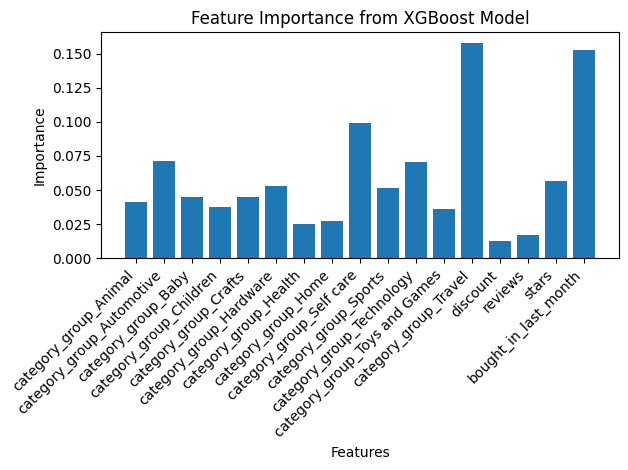

In [ ]:
#feature importance
importance = xgb_clf_optimized.feature_importances_
feature_names = xgb_clf_optimized.feature_names_in_

# Plot the feature importance
plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()
plt.show()

After observing the feature importances for this model, we observed that the amount bought in last month as well as the category of the product (with Travel being the most significant) were strong features that determined whether a product would be a bestseller or not. This differs from the LR model, as that relied almost solely on category with it placing very little comparative importance on amount bought in last month.

##5.4 Random Forest Model

In addition to a Gradient Boosting Model, we implemented a Random Forest Model, an ensemble learning method for classification.

Since Random Forest models are known for being more interpretable and less computationally expensive than XGBoost models, we figured this would be a good alternative to compare.

However, one issue we may run into is lowered accuracy compared to XGBoost.

####5.4.1 Initial Model

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=10, random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

rfc_y_train_pred = rfc.predict(X_train_resampled)
rfc_y_test_pred = rfc.predict(X_test_scaled)

rfc_train_acc = accuracy_score(y_train_resampled, rfc_y_train_pred)
rfc_test_acc = accuracy_score(y_test, rfc_y_test_pred)

rfc_train_recall = recall_score(y_train_resampled, rfc_y_train_pred)
rfc_test_recall = recall_score(y_test, rfc_y_test_pred)

rfc_train_precision = precision_score(y_train_resampled, rfc_y_train_pred)
rfc_test_precision = precision_score(y_test, rfc_y_test_pred)

print(f'Random Forest Classifier Training Accuracy: {rfc_train_acc}')
print(f'Random Forest Classifier Testing Accuracy: {rfc_test_acc}')

print(f'Random Forest Classifier Training Recall: {rfc_train_recall}')
print(f'Random Forest Classifier Testing Recall: {rfc_test_recall}')

print(f'Random Forest Classifier Training Precision: {rfc_train_precision}')
print(f'Random Forest Classifier Testing Precision: {rfc_test_precision}')

Random Forest Classifier Training Accuracy: 0.8539425693814452
Random Forest Classifier Testing Accuracy: 0.8677944950011919
Random Forest Classifier Training Recall: 0.8388677152678412
Random Forest Classifier Testing Recall: 0.7511600928074246
Random Forest Classifier Training Precision: 0.8649455718928255
Random Forest Classifier Testing Precision: 0.03356661482633489


We can see here that while the model performs fairly well, it's accuracy scores aren't as high as those for the XGBoost model, which is a concern that we outlined above as well.

####5.4.2 Hyperparameter Tuning

We performed hyperparameter tuning for this model as well, with more parameters in the param_grid. Note that we performed RandomizedSearchCV once again on the subset of the dataset rather than the full dataset.

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]  # Bootstrapping
}
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_grid,
    n_iter=25,  # Number of random combinations to try
    scoring='accuracy',  # Optimize for recall in imbalanced datasets
    cv=3,  # Use 3-fold cross-validation
    verbose=2,  # Show progress
    n_jobs=-1,  # Utilize all CPU cores
    random_state=42
)

random_search.fit(X_train_subsample, y_train_subsample)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Recall:", random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}
Best Cross-Validated Recall: 0.8802499925761244


The best parameters for this model were found to be {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': False}.

####5.4.3 Final Model

In [ ]:
best_params = random_search.best_params_

rfc_optimized = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)
rfc_optimized.fit(X_train_resampled, y_train_resampled)

y_test_pred = rfc_optimized.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)

Test Accuracy: 0.8946849979668242
Test Recall: 0.6612529002320185
Test Precision: 0.03725611948102879


As a result of hyperparameter tuning, testing accuracy and precision both increased, while testing recall decreased slightly.

####5.4.4 Feature Importances

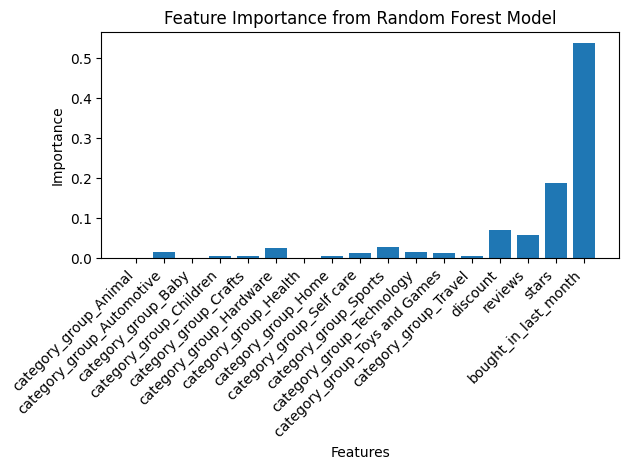

In [ ]:
#feature importance
importance = rfc_optimized.feature_importances_
feature_names = rfc_optimized.feature_names_in_

# Plot the feature importance
plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest Model')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()
plt.show()

Feature importance here showed us that the amount bought in last month is the sole most important feature, while stars (rating) hangs as a far second. Unlike our previous models, we don't see product category as a strong indicator of product status.

#Part 6: Modeling Conclusions and Insights

Based on accuracy scores, we observed that the XGBoost model after hyperparameter tuning was the best model out of the three that we tested. Therefore, by interpreting this predictive model, we can observe which features are most important in our analysis.

The XGBoost model determines that amount bought in last month and category group (with travel being the most prominent) are the highest indicators as to whether a product will achieve best seller status.

Users are more likely to buy products in categories that they require urgently and may not be able to find as easily in an in-person shop. This especially applies to travel, as many travel items are better found online and often bought last minute. Seeing that a product is in demand (via amount bought in last month) may also reassure and encourage users that this product will not disappoint.

#Part 7: Using Reviews to Supplement Analysis

This section of our project is used to supplement our main project. We are now incorporating product reviews using NLP to perform sentiment analysis and determine these can affect product sales. This dataset analysis is done separately as only a portion of the products in our original dataset have corresponding reviews (less than 50k).

##7.1 Setting Up the Reviews Dataframe

First, we load in the reviews dataframe and join it with our cleaned products dataframe on the product id. From here, we drop the duplicated product id column as well as renaming columns so they match our camel case format.

For the reviews dataset, we directly downloaded it from Kaggle and mounted to the local Google Drive. Here is the link to the dataset: [amazon_reviews.csv](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

In [ ]:
reviews_df = pd.read_csv('gdrive/My Drive/amazon_reviews.csv')
reviews_df = reviews_df.drop(columns=['Id'])
reviews_df

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
reviews_products_df = pd.merge(products_df, reviews_df, left_on='product_id', right_on='ProductId')

In [ ]:
reviews_products_df = reviews_products_df.drop(columns=['ProductId', 'ProfileName'])
reviews_products_df.rename(columns={"UserId":"user_id", "HelpfulnessNumerator": "helpfulness_numerator", "HelpfulnessDenominator": "helpfulness_denominator", "Score": "score", "Time": "time", "Summary": "summary", "Text": "review_text", "reviews": "num_reviews"}, inplace = True)
print(reviews_products_df.columns.tolist())

['title', 'stars', 'num_reviews', 'price', 'list_price', 'category_id', 'is_best_seller', 'bought_in_last_month', 'category_name', 'product_id', 'discount', 'category_group', 'binned', 'user_id', 'helpfulness_numerator', 'helpfulness_denominator', 'score', 'time', 'summary', 'review_text']


##7.2 Natural Language Processing

Now, we move on to natural language processing. Through research, we learned that classifiers work more effectively when stopwords are removed and the text is more symmetric. We adjusted the stopwords list by removing any words that we believed had negative or positive connotation. We used **regex** for this filtering process for increased speed.

In [ ]:
# using NLP to classify sentiments
reviews_products_df['review_text'] = reviews_products_df['review_text'].str.lower()

In [ ]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'some', 'such', 'own', 'same', 'so', 's', 't', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']
stopwords_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stopwords) + r')\b'

def remove_stopwords_regex(text):
    return re.sub(stopwords_pattern, '', text, flags=re.IGNORECASE).strip()

# Apply the function to the DataFrame
reviews_products_df['review_text'] = reviews_products_df['review_text'].apply(remove_stopwords_regex)

We used sentiment analysis tools to assist with creating a way to classify sentiment ourselves. The intention was not to use a dataset that had already done some sort of sentiment analysis, so that we could adjust the polarity and sensitivity of the sentiment ourselves. In both of these cases, we have set sentiment to be 1 (positive), 0 (neutral), or -1 (negative). Instead of allowing the full range of decimal values as given by external tools, we are able to classify reviews into smaller groups, which will help the later model and feature importance analysis.

On the review text, we use Text Blob. Text Blob does not require much context or nuance which can be helpful for larger pieces of text.

In [ ]:
from textblob import TextBlob

def classify_function(review):
    # Calculate sentiment polarity (-1 to 1)
    polarity = TextBlob(review).sentiment.polarity

    # Map polarity to sentiment labels
    if polarity > 0.1:
        return 1
    elif polarity < -0.1:
        return -1
    else:
        return 0

reviews_products_df['sentiment'] = reviews_products_df['review_text'].apply(classify_function)

On the summary of the reviews, we use VADER. It is also a lexicon-based sentiment analyzer, and does well at understanding short texts. VADER is actually focused on social media, which means that it works with short and concise words well.

In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_function_short(review):
    # Calculate sentiment polarity (-1 to 1)
    compound_score = sia.polarity_scores(review)['compound']

    # Map polarity to sentiment labels
    if compound_score > 0.1:
        return 1
    elif compound_score < -0.1:
        return -1
    else:
        return 0


# Compute compound sentiment score
reviews_products_df['sentiment_summary'] = reviews_products_df['summary'].apply(classify_function_short)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


After classifying both the review text and review summaries, we want to add this to our reviews_products_df. So, for each product, we find the average of the sentiment for all its reviews. We realize that there exist products in the dataframe that do not have any reviews. To handle this, we fill out every na value with a 0 to represent that as a product with neutral reviews. We do the same thing for the sentiment of the summary of the reviews.

If the summary of the review is more impactful to a product becoming a best seller instead of the whole review, maybe that should be something displayed on the e-commerce site (or vice-versa).


In [ ]:
small_df = reviews_products_df.groupby('product_id')['sentiment'].mean().reset_index()
small_df.rename(columns={'sentiment': 'average_score'}, inplace=True)
products_df = products_df.merge(small_df, on='product_id', how='left', suffixes=('', '_new'))
products_df['average_score'] = products_df['average_score'].fillna(0)

small_df = reviews_products_df.groupby('product_id')['sentiment_summary'].mean().reset_index()
small_df.rename(columns={'sentiment_summary': 'summary_average_score'}, inplace=True)
products_df = products_df.merge(small_df, on='product_id', how='left', suffixes=('', '_new'))
products_df['summary_average_score'] = products_df['summary_average_score'].fillna(0)

Here, we run our XGBoost with the same code as section **5.3**. This way, we get to see the importance of the sentiment of the review and sentiment of the summary.


In [ ]:
X = products_df[['discount', 'reviews', 'stars', 'category_group', 'bought_in_last_month', 'average_score', 'summary_average_score']]
y = products_df['is_best_seller']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

to_encode = ['category_group']
not_encode = ['discount', 'reviews', 'stars', 'bought_in_last_month', 'average_score', 'summary_average_score']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(X_train[to_encode])
X_train_encoded_df = pd.DataFrame(encoder.transform(X_train[to_encode]), columns=encoder.get_feature_names_out(to_encode))
X_test_encoded_df = pd.DataFrame(encoder.transform(X_test[to_encode]), columns=encoder.get_feature_names_out(to_encode))

X_train_encoded_full = pd.concat([X_train_encoded_df, pd.DataFrame(X_train[not_encode]).reset_index(drop=True)], axis=1)
X_test_encoded_full = pd.concat([X_test_encoded_df, pd.DataFrame(X_test[not_encode]).reset_index(drop=True)], axis=1)

X_train_scaled = X_train_encoded_full.copy(deep=True)
X_test_scaled = X_test_encoded_full.copy(deep=True)

scaler = StandardScaler()

scaler.fit(X_train_scaled[not_encode])
X_train_scaled[not_encode] = scaler.transform(X_train_scaled[not_encode])
X_test_scaled[not_encode] = scaler.transform(X_test_scaled[not_encode])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
#Best set of hyperparameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}

xgb_clf_optimized = XGBClassifier(random_state=42, tree_method='hist', n_estimators=200, max_depth=15)
xgb_clf_optimized.fit(X_train_resampled, y_train_resampled)

y_test_pred = xgb_clf_optimized.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)


Test Accuracy: 0.92966613850835
Test Recall: 0.3468677494199536
Test Precision: 0.03061015561015561


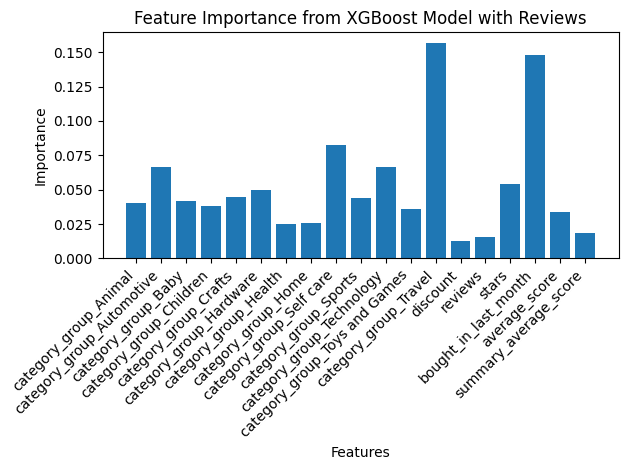

In [ ]:
#feature importance
importance = xgb_clf_optimized.feature_importances_
feature_names = xgb_clf_optimized.feature_names_in_

# Plot the feature importance
plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from XGBoost Model with Reviews')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()
plt.show()

For this model, our accuracy remains high. It is interesting to note that sentiment of the summary and sentiment of the review, while important, do not have the nearly same impact on best sellers as the previous frontrunner (amount bought in last month).

##7.3 Analyzing Review Emotions

While we could stop here, we can extract one more attribute from each review. In addition to measuring sentiment, which is purely a numerical representation of positivity/negativity, we decided that additionally determining the specific emotions in the reviews of a product could be a useful addition to our model in determining whether or not a product attains best-seller status.

We will approach this problem by creating and training a Convolutional Neural Network that can determine the primary emotion of each review and assign one of six categorical variables to each one: **0 for 'sadness', 1 for 'joy', 2 for 'love', 3 for 'anger', 4 for 'fear', and 5 for 'surprise.'** While another method of doing this would be using the BERT model to embed (after tokenizing) each twitter post and then feeding in these values into a fully connected neural network (no convolutional layers), we realized that this approach was too computationally expensive for our large dataset, taking multiple hours to obtain the embeddings for each value in our large twitter post data set. Using a CNN, which can similarly determine the relationships of words in context would be a faster approach to solve the same problem. In this method, we also embed each word in the neural network using nn.Embedding(), an alternative to BERT embeddings that embeds each worth without taking note of the words around it. Instead, the role of determining the relationships between words is handed to the convolutional layers of the CNN, a less computationally expensive method.

We'll start by setting the seed of torch for consistency:

In [ ]:
torch.manual_seed(42)

####7.3.1 CNN Training Data Cleaning


Next, we will clean the dataset 'text.csv' which we will use to train and test our CNN. This csv file contains 300,000 relatively short twitter posts and, in a secondary column, the primary emotion associated with each one. Let's begin by taking a look at the dataset.

For the emotion and texts dataset, we directly downloaded it from Kaggle and mounted to the local Google Drive. Here is the link to the dataset: [text.csv](https://www.kaggle.com/datasets/nelgiriyewithana/emotions?resource=download)

In [ ]:
emotions_df = pd.read_csv('gdrive/My Drive/text.csv')
emotions_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


While we could map the numerical values that represent each emotion in the 'label' column to their string representation (replace all 0's with 'sadness', etc.), this would make it difficult for the CNN to predict y values for the X_test dataset and for our real amazon_products reviews. Therefore, we will leave them as is but note what each number in this 'label' column represents:

**0**: sadness

**1**: joy

**2**: love

**3**: anger

**4**: fear

**5**: surprise

Additionally, we will convert every character to lowercase in this column in order to standardize the words that the CNN is working with and allow it to draw more conclusions that aren't limited by variations in the same word's capitalization across different reviews:

In [ ]:
emotions_df['text'] = emotions_df['text'].str.lower()
emotions_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


Next, we will take a random 10,000 value sample of our 300,000 value dataset, because training the CNN with a dataset of any more than 10,000 values is too computationally expensive.

In [ ]:
emotions_df_2 = emotions_df.sample(n=10000, random_state=42)
emotions_df_2 = emotions_df_2.reset_index(drop=True)
emotions_df_2.head()

,Unnamed: 0,text,label
0,36130,id say maybe made them feel foolish but that w...,0
1,138065,i joined the lds church i admit to feeling som...,0
2,146440,i must admit i didnt feel like hugging him not...,3
3,103337,i hate that i can still feel if any nerve is d...,0
4,315528,im actually feeling a little smug,1


We will now split this subset of our data, saved in emotions_df_2, into our training and testing datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(emotions_df_2['text'], emotions_df_2['label'], test_size=0.2, random_state=42)

####7.3.2 Tokenization + Data Loader Creation

Next, in order for our CNN to be able to process this data, we must tokenize each Twitter post. We do this using DistilBertTokenizer.
The first step here is creating the tokenizer.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Using our newly made tokenizer, we create the method called get_tokens, which takes in each tweet in our training data and tokenizes it. Our 'padding', 'truncation', and 'max_length' parameters ensure that the dimensions of each value we add to 'tokenized_text' are the same.

In [ ]:
def get_tokens(texts, tokenizer, max_len=128):
    tokenized_texts = []
    for text in texts:
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
        tokenized_texts.append(inputs['input_ids'].squeeze().numpy())
    return tokenized_texts

X_train_list = X_train.tolist()
train_tokenized = get_tokens(X_train_list, tokenizer)

We also create a dataloader that will allow us to input our data into the CNN.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        # Converting the list of tokenized texts to a tensor
        tokens = torch.tensor(self.tokenized_texts[idx])
        label = torch.tensor(self.labels[idx])
        return tokens, label

train_dataset = TextDataset(train_tokenized, y_train.tolist())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

####7.3.3 CNN Architecture

Next, we create the actual CNN, which contains 2 convolutional layers. While we initially only had one, our accuracy was not as high as we had hoped so we added a second convolutional layer in hopes that our model would be able to recognize more complex relationships between the words in our data.

Additionally, our CNN includes two fully connected layers, and it uses the ReLU activation function.

Note: We dynamically calculate the size of our first fully connected layer in our CNN code since we wanted to be able to pass in sequence_length as a parameter to our CNN for easy manipulation.

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, sequence_length):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # First Convolutional Layer
        self.conv1 = nn.Conv1d(embed_size, 64, kernel_size=5, padding=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()

        # Dynamically calculate the size for the fully connected layer
        self.fc1 = None  # Placeholder
        self.fc2 = nn.Linear(128, num_classes)

        self.sequence_length = sequence_length

    def forward(self, x):
        x = self.embedding(x)  # Convert token IDs to embeddings
        x = x.transpose(1, 2)  # Change shape to (batch_size, embed_size, sequence_length) for Conv1D

        # Apply first convolutional layer
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Apply second convolutional layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Dynamically calculate the size for the fully connected layer
        flattened_size = x.size(1) * x.size(2)  # 128 * (sequence_length // 4) dynamically
        if self.fc1 is None:
            self.fc1 = nn.Linear(flattened_size, 128)

        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x


####7.3.4 Training CNN

Next, we instantiate TextCNN to create our cnn, and then we train this model on our training data, printing out the new, updated accuracy with each epoch. While increasing the number of epochs may have increased the accuracy of our model slightly, anything larger than 40 would have been too computationally expensive. We reach 97.15% accuracy through this training procedure.

In [ ]:
# This is the vocab size for BERT's tokenizer
vocab_size = 30522
embed_size = 256
# 6 emotions
num_classes = 6
sequence_length = 512
device = torch.device("cpu")
cnn = TextCNN(vocab_size, embed_size, num_classes, sequence_length).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)

epochs = 40

acc_LIST_CNN = []
loss_LIST_CNN = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (predictions == labels).sum().item()
        total += len(labels)

    accuracy = 100 * correct / total
    acc_LIST_CNN.append(accuracy)
    loss_LIST_CNN.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/40], Loss: 1.6108, Accuracy: 34.33%
Epoch [2/40], Loss: 1.5780, Accuracy: 34.21%
Epoch [3/40], Loss: 1.5731, Accuracy: 34.34%
Epoch [4/40], Loss: 1.5659, Accuracy: 34.79%
Epoch [5/40], Loss: 1.5559, Accuracy: 35.48%
Epoch [6/40], Loss: 1.5389, Accuracy: 38.73%
Epoch [7/40], Loss: 1.5119, Accuracy: 42.65%
Epoch [8/40], Loss: 1.4716, Accuracy: 44.96%
Epoch [9/40], Loss: 1.4205, Accuracy: 47.60%
Epoch [10/40], Loss: 1.3587, Accuracy: 50.25%
Epoch [11/40], Loss: 1.2925, Accuracy: 52.95%
Epoch [12/40], Loss: 1.2257, Accuracy: 55.71%
Epoch [13/40], Loss: 1.1581, Accuracy: 58.79%
Epoch [14/40], Loss: 1.0944, Accuracy: 61.09%
Epoch [15/40], Loss: 1.0325, Accuracy: 63.86%
Epoch [16/40], Loss: 0.9714, Accuracy: 66.71%
Epoch [17/40], Loss: 0.9129, Accuracy: 69.12%
Epoch [18/40], Loss: 0.8574, Accuracy: 71.30%
Epoch [19/40], Loss: 0.8052, Accuracy: 73.14%
Epoch [20/40], Loss: 0.7567, Accuracy: 75.19%
Epoch [21/40], Loss: 0.7089, Accuracy: 77.39%
Epoch [22/40], Loss: 0.6639, Accuracy: 79.1

####7.3.5 Testing the CNN + Accuracy Measurements

Now, in order to *test* our model, we will focus on formatting our test data the same way we formatted the training data so that our TextCNN can process it. This involves tokenizing and creating a testing data loader.

In [ ]:
X_test_list = X_test.tolist()
test_tokens = get_tokens(X_test_list, tokenizer)
test_dataset = TextDataset(test_tokens, y_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

We finally input our testing data (Twitter posts) into the model, getting a numerical value for each one to represent which emotion each post is most heavily correlated with.

In [ ]:
import pandas as pd

predictions_list = []
texts_list = []
correct = 0
total = 0

cnn.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = cnn(inputs)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += len(labels)
        predictions_list.extend(predictions.cpu().numpy())
        texts_list.extend(inputs.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Here, we print out the first 10 Twitter texts and their predicted emotions
df_new = pd.DataFrame({
    'Text': texts_list[:10],
    'Predicted Label': predictions_list[:10]
})
print(df_new)


Test Accuracy: 61.25%
                                                Text  Predicted Label
0  [101, 1045, 2113, 2049, 5958, 1998, 2012, 2023...                1
1  [101, 1045, 2514, 2062, 1998, 2062, 8916, 2008...                1
2  [101, 1045, 2572, 7591, 2055, 2108, 5845, 7199...                0
3  [101, 1045, 8971, 27084, 2401, 8553, 7199, 209...                4
4  [101, 1045, 2156, 2083, 1996, 9376, 2895, 2000...                0
5  [101, 1045, 2106, 2174, 2514, 22614, 1998, 224...                3
6  [101, 1045, 2514, 2200, 9662, 2055, 14739, 202...                4
7  [101, 1045, 2179, 2008, 2009, 2187, 2026, 3096...                1
8  [101, 1045, 2572, 3110, 2785, 1997, 13026, 287...                2
9  [101, 1045, 2228, 2023, 2003, 2138, 1996, 2270...                0


####7.3.6 Applying CNN to Reviews

Now that our model is working, we can finally apply it to our Amazon reviews dataset. Please note that we use reviews_products_df here as opposed to reviews_df because it contains only the reviews that have product ID's in our products_df dataset, filtering out the reviews that are not applicable to us.

We begin by creating an InferenceDataset class, which operates exactly the same as the TextDataset class, but without dealing with labels.

In [ ]:
class InferenceDataset(Dataset):
  def __init__(self, tokenized_texts):
    self.tokenized_texts = tokenized_texts

  def __len__(self):
    return len(self.tokenized_texts)

  def __getitem__(self, idx):
    tokens = torch.tensor(self.tokenized_texts[idx])
    return tokens

class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        # Converting the list of tokenized texts to a tensor
        tokens = torch.tensor(self.tokenized_texts[idx])
        label = torch.tensor(self.labels[idx])
        return tokens, label

In [ ]:
only_reviews = reviews_products_df['review_text'].tolist()
only_reviews_tokenized = get_tokens(only_reviews, tokenizer)
only_reviews_dataset = InferenceDataset(only_reviews_tokenized)

Then, we run our model on our reviews data, making sure to set shuffle to False to ensure that our data remains in the correct order even though we are using a loader. These predictions are saved in a matrix called predictions_emotions, which has 6 columns, and a value in each one representing that row's review's correlation with that emotion.

In [ ]:
reviews_loader = DataLoader(only_reviews_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn.to(device)

cnn.eval()

predictions = []

with torch.no_grad():
    for batch in reviews_loader:
        batch = batch.to(device)
        batch_predictions = cnn(batch)
        predictions.append(batch_predictions)

predictions_emotions = torch.cat(predictions, dim=0)

Next, we use torch.argmax to find which emotion each review is most correlated with, and we add a new column with this value to reviews_products_df.

In [ ]:
predicted_classes = torch.argmax(predictions_emotions, dim=1)

# Here, we are converting the tensor of predicted classes to a Pandas Series
predicted_classes_series = pd.Series(predicted_classes.numpy())

In [ ]:
# Add the series as a new column in the DataFrame
reviews_products_df['predictions_emotions'] = predicted_classes_series

# Verify the update
print(reviews_products_df.head())

                                               title  stars  num_reviews  \
0  Dabur Kachi Ghani Mustard Oil - Oil for Skin a...    4.3          549   
1  Dabur Kachi Ghani Mustard Oil - Oil for Skin a...    4.3          549   
2  Rhode Island Novelty 27mm Assorted Bounce Ball...    4.6          936   
3  Rhode Island Novelty 27mm Assorted Bounce Ball...    4.6          936   
4  Rhode Island Novelty 27mm Assorted Bounce Ball...    4.6          936   

   price  list_price  category_id  is_best_seller  bought_in_last_month  \
0  14.99        0.00          128               0                   100   
1  14.99        0.00          128               0                   100   
2  18.60       24.99          230               0                   100   
3  18.60       24.99          230               0                   100   
4  18.60       24.99          230               0                   100   

                    category_name  product_id  ...         user_id  \
0  Wellness & Relaxati

We will now count how many reviews of each emotion there are for every product in products_df, and add 6 new columns to products_df to keep track of this count.

In [ ]:
for emotion in range(6):
    products_df[f'emotion_{emotion}'] = 0

# Looping through each row of reviews_df
for _, row in reviews_products_df.iterrows():
    product_id = row['product_id']
    emotion = row['predictions_emotions']

    # Incrementing the corresponding emotion column in products_df for the given product_id
    products_df.loc[products_df['product_id'] == product_id, f'emotion_{emotion}'] += 1


Here we check to make sure that the emotion columns were correcty populated and are not 0 for every product in our dataframe.

In [ ]:
for emotion in range(6):
  count_non_zero = (products_df[f'emotion_{emotion}'] != 0).sum()
  print(count_non_zero != 0)

True
True
True
True
True
True


##7.4 Running Final Model

Again, we use XGBoost in the same way as section **5.3** to analyze our dataframe with the emotion columns added.

In [ ]:
X = products_df[['discount', 'reviews', 'stars', 'category_group', 'bought_in_last_month', 'average_score', 'summary_average_score', 'emotion_0', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5']]
y = products_df['is_best_seller']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

to_encode = ['category_group']
not_encode = ['discount', 'reviews', 'stars', 'bought_in_last_month', 'average_score', 'summary_average_score', 'emotion_0', 'emotion_1', 'emotion_2', 'emotion_3', 'emotion_4', 'emotion_5']

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(X_train[to_encode])
X_train_encoded_df = pd.DataFrame(encoder.transform(X_train[to_encode]), columns=encoder.get_feature_names_out(to_encode))
X_test_encoded_df = pd.DataFrame(encoder.transform(X_test[to_encode]), columns=encoder.get_feature_names_out(to_encode))

X_train_encoded_full = pd.concat([X_train_encoded_df, pd.DataFrame(X_train[not_encode]).reset_index(drop=True)], axis=1)
X_test_encoded_full = pd.concat([X_test_encoded_df, pd.DataFrame(X_test[not_encode]).reset_index(drop=True)], axis=1)

X_train_scaled = X_train_encoded_full.copy(deep=True)
X_test_scaled = X_test_encoded_full.copy(deep=True)

scaler = StandardScaler()

scaler.fit(X_train_scaled[not_encode])
X_train_scaled[not_encode] = scaler.transform(X_train_scaled[not_encode])
X_test_scaled[not_encode] = scaler.transform(X_test_scaled[not_encode])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

In [ ]:
#Best set of hyperparameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}

xgb_clf_optimized = XGBClassifier(random_state=42, tree_method='hist', n_estimators=200, max_depth=15)
xgb_clf_optimized.fit(X_train_resampled, y_train_resampled)

y_test_pred = xgb_clf_optimized.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)

Test Accuracy: 0.9295504578151071
Test Recall: 0.35556844547563804
Test Precision: 0.03127710597479463


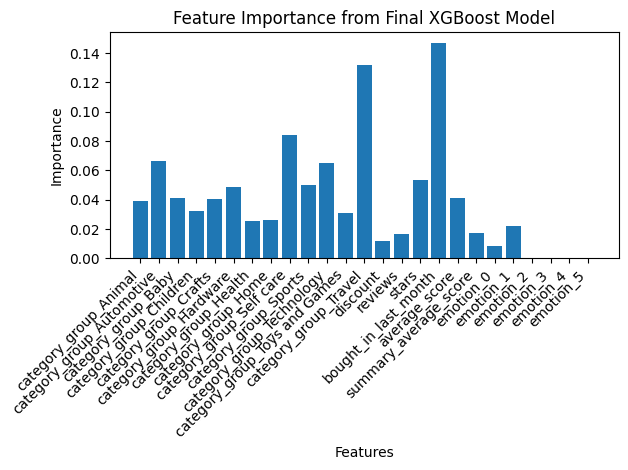

In [ ]:
#feature importance
importance = xgb_clf_optimized.feature_importances_
feature_names = xgb_clf_optimized.feature_names_in_

# Plot the feature importance
plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Final XGBoost Model')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better visibility
plt.tight_layout()
plt.show()

Out of our new feature additions, similar to our previous conclusions, the travel category and amount of the product bought in the last month remain important. However, we also see that the second emotion, **love**, may also be important for a product to have best seller status. Overall, we can say that the sentiment and emotions of reviews may not be as important is swaying consumers and turning products into best sellers.

#Part 8: ER Diagram

Below is the ER Diagram of our final set up of data. Since we conducted multiple joins, we wanted to visualize how our multiple datasets were related from products to categories to reviews.

**For products**, the information we needed in our analysis included product id, title, stars, number of reviews, price, list price, category id, is best seller, and amount bought in last month. From this given information, we were also able to calculate discount for products.

**For categories**, we had the id and name of the category.

**For reviews**, the information kept was the user id, helpfulness numerator, helpfulness denominator, score, time, summary, and text. For our analysis, we mainly just used the review text. It was not necessary for our modelling but to flesh out the ER diagram, you could also calculate the overall helpfulness of the review.

The primary key for reviews is a bit tricky, since there is no review id. So, for the sake of representation, we use composite attributes to comprise review id, which would include product id, user id, and time to make sure each review id is unique (if we did not include time, there is a case when the same user could leave a review about the same product).

**Relationships:**

A product can be described multiple reviews. A review can describe one product.

A product can have one category. A category can contain multiple products.

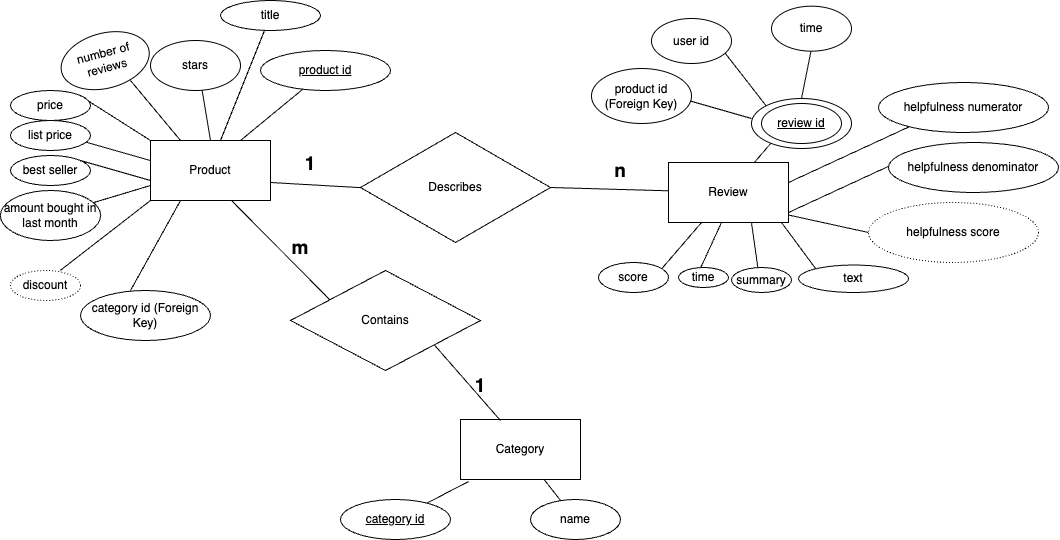

#Part 9: Conclusion

Our overall conclusions of features of importance are emphasized by the visuals above. XGBoost was the most accurate model and outputted that the amount a product was bought as well as its category group (travel) were most important features in determining if a product was a best seller.

We made sure to detect and handle our imbalanced data when it came to products that were best sellers, we conducted feature engineering to create new features and encode them, and we systematically chose hyperparameter tuning techniques. Throughout out modeling process, we specifically used interpretable models because we knew that would be better than a predictive model because we care about the importance of each input feature more than predicting if the product was a best seller. On top of this, we learned how to apply many course topics that were necessary for our project including pandas, regex, joins, unsupervised learning models, and an ER diagram.

Some challenges and limitations included many computationally expensive tasks such as training the models, hyperparameter tuning, and tokenizing the text. One of our main challenges with the reviews analysis was that once we joined our products and reviews dataset, there were significantly fewer rows. There was less data to work with so information we extracted from the reviews was less significant to our model.

We hope to be able to analyze different kinds of features in the future. Being able to answer the following questions would lead to completely new insights for businesses and consumers.
*   How does the best seller status of a product change over time, and what factors contribute to it losing its bestseller status?
*   Does the popularity and quality of a product’s brand correlate with it becoming a bestseller?
*   Are these individual features of importance the same across the various countries in which Amazon operates?

Overall, through our project we were able to find key insights about how visible features on e-commerce platforms may entice a user to buy and rate products, eventually listing the product as a best seller. This information could be useful to stakeholders and business owners as they choose what content to display on their websites and to their customers.